In [6]:
import pandas as pd
import plotly.express as px

## Dataset from [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv)

In [36]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [37]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [38]:
data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


## Creating Moving Averages

In [39]:
data['MA48'] = data['value'].rolling(48).mean()

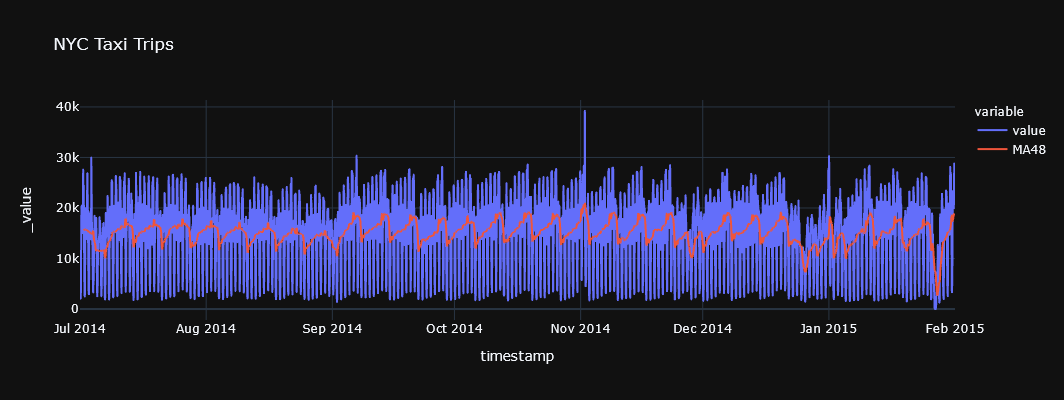

In [40]:
fig = px.line(data, x="timestamp", y=['value', 'MA48'],
              title='NYC Taxi Trips', template = 'plotly_dark', width=800, height=400)
fig.show()

## Data Preparation

In [41]:
# Extracting time data from timestamp column

In [42]:
data.drop(['MA48'], axis = 1, inplace = True)

In [43]:
# set timestamp to index
data.set_index('timestamp', drop=True, inplace=True)

In [44]:
# resample timeseries to hourly
data = data.resample('H').sum()

In [46]:
# creature features from date
data['day'] = [i.day for i in data.index]

In [50]:
data['day_name'] = [i.day_name() for i in data.index]

In [60]:
data['day_of_year'] = [i.dayofyear for i in data.index]
data['week_of_year'] = [i.weekofyear for i in data.index]
data['Hour'] = [i.hour for i in data.index]
data['is_weekday'] = [i.isoweekday() for i in data.index]

In [62]:
# init setup
from pycaret.anomaly import *
s = setup(data, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(5160, 7)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(5160, 19)"
9,CPU Jobs,-1


In [63]:
# check list of available models
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [104]:
# train model
# I lower the fraction of outliers from 0.1 (Tutorial) to 0.01. That reproduces similar result than the tutorial.  

iforest = create_model('iforest', fraction = 0.01)
iforest_results = assign_model(iforest)
iforest_results.head()

,value,day,day_name,day_of_year,week_of_year,Hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,0,-0.049065
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2,0,-0.039983
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2,0,-0.044604
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,0,-0.050707
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2,0,-0.050621


In [105]:
# check anomalies
iforest_results[iforest_results['Anomaly'] == 1].head()

,value,day,day_name,day_of_year,week_of_year,Hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2015-01-01 00:00:00,51700,1,Thursday,1,1,0,4,1,0.031136
2015-01-01 01:00:00,58584,1,Thursday,1,1,1,4,1,0.028444
2015-01-01 02:00:00,51507,1,Thursday,1,1,2,4,1,0.026249
2015-01-01 03:00:00,44134,1,Thursday,1,1,3,4,1,0.011734
2015-01-01 04:00:00,30799,1,Thursday,1,1,4,4,1,0.004279


## Plot anomalies on the graph to visualize

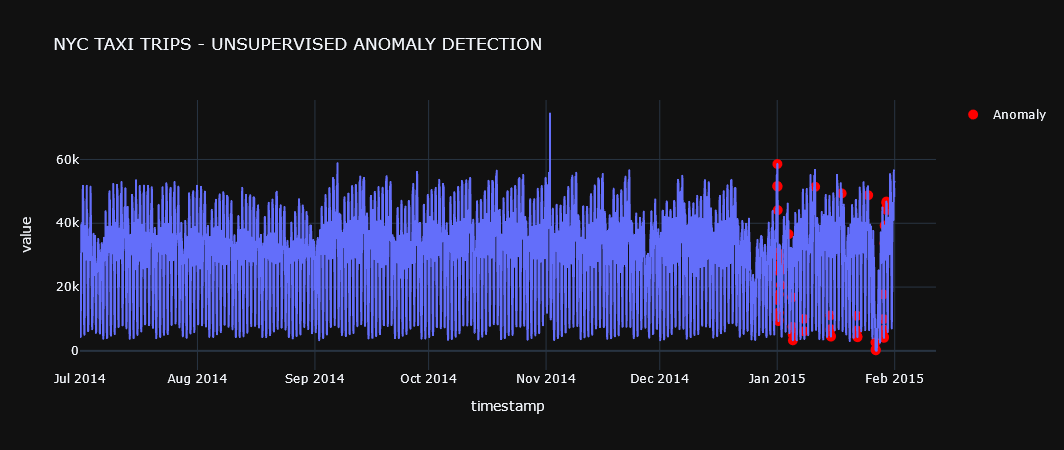

In [106]:
import plotly.graph_objects as go

# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index,
              y="value", title='NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')

# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index

y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]

fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, 
                         mode = 'markers', 
                         name = 'Anomaly', 
                         marker=dict(color='red',size=10)))
        
fig.show()